<a href="https://colab.research.google.com/github/muhammad-usama-aleem/finetuned_Blip/blob/main/Finetune_Blip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 933.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.8 MB/s eta 0:00:00


In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

In [4]:
from datasets import load_dataset 

dataset = load_dataset("ybelkada/football-dataset", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ybelkada___parquet/ybelkada--football-dataset-1ad065f8e9005a29/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [5]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 6
})

In [6]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

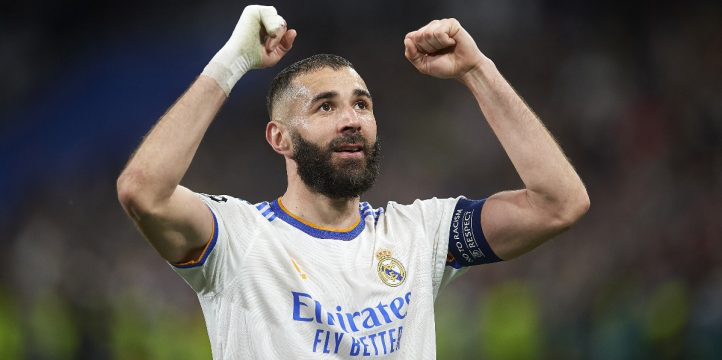

In [7]:
dataset[0]["image"]

In [8]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [9]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [10]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

In [12]:
for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 13.07715892791748
Loss: 10.244012832641602
Loss: 10.245245933532715
Epoch: 1
Loss: 10.184503555297852
Loss: 10.204593658447266
Loss: 10.1744384765625
Epoch: 2
Loss: 10.134867668151855
Loss: 10.172049522399902
Loss: 10.109891891479492
Epoch: 3
Loss: 10.115257263183594
Loss: 10.110862731933594
Loss: 10.092935562133789
Epoch: 4
Loss: 10.11588191986084
Loss: 10.063088417053223
Loss: 10.036730766296387
Epoch: 5
Loss: 10.034835815429688
Loss: 10.013989448547363
Loss: 10.024564743041992
Epoch: 6
Loss: 9.97109317779541
Loss: 9.826958656311035
Loss: 9.386707305908203
Epoch: 7
Loss: 9.1860933303833
Loss: 8.907574653625488
Loss: 8.752548217773438
Epoch: 8
Loss: 8.496843338012695
Loss: 8.266629219055176
Loss: 8.10165786743164
Epoch: 9
Loss: 7.921860694885254
Loss: 7.714334964752197
Loss: 7.56490421295166
Epoch: 10
Loss: 7.401589393615723
Loss: 7.293177604675293
Loss: 7.114688873291016
Epoch: 11
Loss: 6.980075836181641
Loss: 6.812084674835205
Loss: 6.71523380279541
Epoch: 12
Loss: 6.

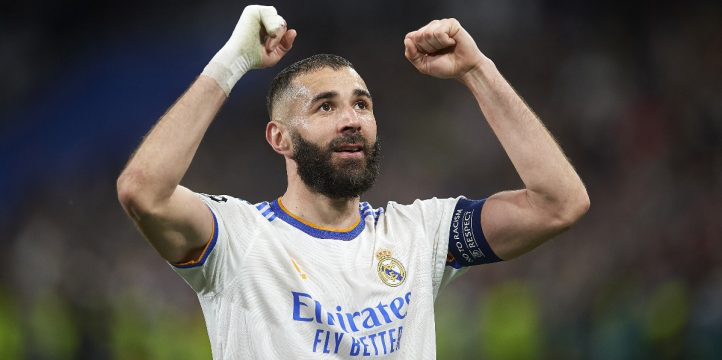

In [13]:
# load image
example = dataset[0]
image = example["image"]
image

In [14]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

benzema after real mardid's win against psg
